## Advanced Convolutions

* This notebook is intended to play with advanced convolutions and understand how the layers changes size and channels


### Import necessary modules

In [0]:
from keras import backend as K
import time
import matplotlib.pyplot as plt
import numpy as np
% matplotlib inline
np.random.seed(2017) 

from keras import regularizers
from keras.models import Sequential
from keras.layers.convolutional import Convolution2D, MaxPooling2D, SeparableConv2D
from keras.layers import Activation, Flatten, Dense, Dropout
from keras.layers.normalization import BatchNormalization
from keras.utils import np_utils

In [0]:
from keras.datasets import cifar10
(train_features, train_labels), (test_features, test_labels) = cifar10.load_data()
num_train, img_channels, img_rows, img_cols =  train_features.shape
num_test, _, _, _ =  test_features.shape
num_classes = len(np.unique(train_labels))

#### Visualzing dataset

* Its very important to visualize that dataset to understand the complexity of features the network should learn
* It also helps in understanding what sort of image augmentation should be applied to the datasets

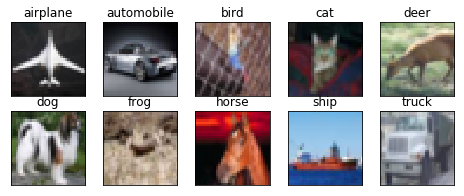

In [3]:
class_names = ['airplane','automobile','bird','cat','deer',
               'dog','frog','horse','ship','truck']
fig = plt.figure(figsize=(8,3))
for i in range(num_classes):
    ax = fig.add_subplot(2, 5, 1 + i, xticks=[], yticks=[])
    idx = np.where(train_labels[:]==i)[0]
    features_idx = train_features[idx,::]
    img_num = np.random.randint(features_idx.shape[0])
    im = features_idx[img_num]
    ax.set_title(class_names[i])
    plt.imshow(im)
plt.show()

#### Helper functions

* Following are helper functions to understand how network performed
* It plots graph on model accuracy and loss for training vs validation dataset over increasing epochs

In [0]:
def plot_model_history(model_history):
    fig, axs = plt.subplots(1,2,figsize=(15,5))
    # summarize history for accuracy
    axs[0].plot(range(1,len(model_history.history['acc'])+1),model_history.history['acc'])
    axs[0].plot(range(1,len(model_history.history['val_acc'])+1),model_history.history['val_acc'])
    axs[0].set_title('Model Accuracy')
    axs[0].set_ylabel('Accuracy')
    axs[0].set_xlabel('Epoch')
    axs[0].set_xticks(np.arange(1,len(model_history.history['acc'])+1),len(model_history.history['acc'])/10)
    axs[0].legend(['train', 'val'], loc='best')
    # summarize history for loss
    axs[1].plot(range(1,len(model_history.history['loss'])+1),model_history.history['loss'])
    axs[1].plot(range(1,len(model_history.history['val_loss'])+1),model_history.history['val_loss'])
    axs[1].set_title('Model Loss')
    axs[1].set_ylabel('Loss')
    axs[1].set_xlabel('Epoch')
    axs[1].set_xticks(np.arange(1,len(model_history.history['loss'])+1),len(model_history.history['loss'])/10)
    axs[1].legend(['train', 'val'], loc='best')
    plt.show()

In [0]:
def accuracy(test_x, test_y, model):
    result = model.predict(test_x)
    predicted_class = np.argmax(result, axis=1)
    true_class = np.argmax(test_y, axis=1)
    num_correct = np.sum(predicted_class == true_class) 
    accuracy = float(num_correct)/result.shape[0]
    return (accuracy * 100)

#### Pixel Normalization

* It is good to rescale dataset, so that network sees image in same range and hence makes it easy to learn

In [0]:
train_features = train_features.astype('float32')/255
test_features = test_features.astype('float32')/255
# convert class labels to binary class labels
train_labels = np_utils.to_categorical(train_labels, num_classes)
test_labels = np_utils.to_categorical(test_labels, num_classes)

#### Not-So-Ideal Network

* Following is network is not an ideal architecture
* Some issues:
  * Dropout in last layer
  * Dense layers
  * Increasing channels
  * Dropout value is high (0.25)
  * No Batch Normalization
* Some ways to fix it:
  * No Dropout in last layer
  * Remove Dense layers
  * Have network with alternating high channels & low channels (squeeze & excite)
  * Add Batch Normalization
  * Add Image Normalization
  * Add Image Augmentation
  

In [0]:
# Define the model
model = Sequential()
model.add(Convolution2D(48, 3, 3, border_mode='same', input_shape=(32, 32, 3))) # Output: 32x32x48, RF: 3
model.add(Activation('relu')) 
model.add(Convolution2D(48, 3, 3)) # Output: 30x30x48, RF: 5
model.add(Activation('relu'))
model.add(MaxPooling2D(pool_size=(2, 2))) # Output: 15x15x48, RF: 10
model.add(Dropout(0.25))
model.add(Convolution2D(96, 3, 3, border_mode='same')) # Output: 15x15x96, RF: 12
model.add(Activation('relu'))
model.add(Convolution2D(96, 3, 3)) # Output: 13x13x96, RF: 14
model.add(Activation('relu'))
model.add(MaxPooling2D(pool_size=(2, 2))) # Output: 6x6x96, RF: 28
model.add(Dropout(0.25))
model.add(Convolution2D(192, 3, 3, border_mode='same')) # Output: 6x6x192, RF: 30
model.add(Activation('relu'))
model.add(Convolution2D(192, 3, 3)) # Output: 4x4x192, RF: 32
model.add(Activation('relu'))
model.add(MaxPooling2D(pool_size=(2, 2))) # Output: 2x2x192, RF: 64
model.add(Dropout(0.25))
model.add(Flatten())
model.add(Dense(512))
model.add(Activation('relu'))
model.add(Dropout(0.5))
model.add(Dense(256))
model.add(Activation('relu'))
model.add(Dropout(0.5))
model.add(Dense(num_classes, activation='softmax'))
# Compile the model
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:2: UserWarning: Update your `Conv2D` call to the Keras 2 API: `Conv2D(48, (3, 3), input_shape=(32, 32, 3..., padding="same")`
  
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:4: UserWarning: Update your `Conv2D` call to the Keras 2 API: `Conv2D(48, (3, 3))`
  after removing the cwd from sys.path.
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:8: UserWarning: Update your `Conv2D` call to the Keras 2 API: `Conv2D(96, (3, 3), padding="same")`
  
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:10: UserWarning: Update your `Conv2D` call to the Keras 2 API: `Conv2D(96, (3, 3))`
  # Remove the CWD from sys.path while we load stuff.
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:14: UserWarning: Update your `Conv2D` call to the Keras 2 API: `Conv2D(192, (3, 3), padding="same")`
  
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:16: UserWarning: Update your `Conv2D` 

In [0]:
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_7 (Conv2D)            (None, 32, 32, 48)        1344      
_________________________________________________________________
activation_9 (Activation)    (None, 32, 32, 48)        0         
_________________________________________________________________
conv2d_8 (Conv2D)            (None, 30, 30, 48)        20784     
_________________________________________________________________
activation_10 (Activation)   (None, 30, 30, 48)        0         
_________________________________________________________________
max_pooling2d_4 (MaxPooling2 (None, 15, 15, 48)        0         
_________________________________________________________________
dropout_6 (Dropout)          (None, 15, 15, 48)        0         
_________________________________________________________________
conv2d_9 (Conv2D)            (None, 15, 15, 96)        41568     
__________

#### Run the network and examine output

* Base accuracy = 84.05 (87th Epoch)

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:12: UserWarning: The semantics of the Keras 2 argument `steps_per_epoch` is not the same as the Keras 1 argument `samples_per_epoch`. `steps_per_epoch` is the number of batches to draw from the generator at each epoch. Basically steps_per_epoch = samples_per_epoch/batch_size. Similarly `nb_val_samples`->`validation_steps` and `val_samples`->`steps` arguments have changed. Update your method calls accordingly.
  if sys.path[0] == '':
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:12: UserWarning: Update your `fit_generator` call to the Keras 2 API: `fit_generator(<keras_pre..., validation_data=(array([[[..., verbose=1, steps_per_epoch=390, epochs=100)`
  if sys.path[0] == '':


Epoch 1/100
390/390 [==============================] - 24s 61ms/step - loss: 1.8493 - acc: 0.2934 - val_loss: 1.5250 - val_acc: 0.4335
Epoch 2/100
390/390 [==============================] - 22s 56ms/step - loss: 1.3320 - acc: 0.5197 - val_loss: 1.1241 - val_acc: 0.5975
Epoch 3/100
390/390 [==============================] - 22s 56ms/step - loss: 1.1064 - acc: 0.6112 - val_loss: 0.9468 - val_acc: 0.6651
Epoch 4/100
390/390 [==============================] - 22s 56ms/step - loss: 0.9730 - acc: 0.6601 - val_loss: 0.8628 - val_acc: 0.6932
Epoch 5/100
390/390 [==============================] - 22s 56ms/step - loss: 0.8692 - acc: 0.6979 - val_loss: 0.7596 - val_acc: 0.7394
Epoch 6/100
390/390 [==============================] - 22s 56ms/step - loss: 0.7948 - acc: 0.7268 - val_loss: 0.7441 - val_acc: 0.7461
Epoch 7/100
390/390 [==============================] - 22s 56ms/step - loss: 0.7396 - acc: 0.7465 - val_loss: 0.6976 - val_acc: 0.7577
Epoch 8/100
390/390 [==============================] - 

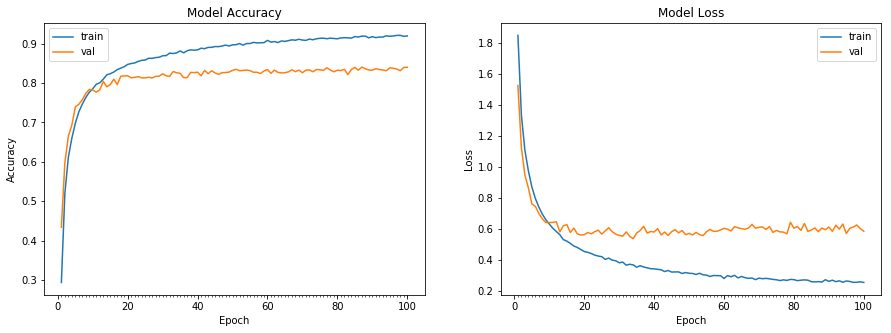

Accuracy on test data is: 84.01


In [0]:
from keras.preprocessing.image import ImageDataGenerator

datagen = ImageDataGenerator(zoom_range=0.0, 
                             horizontal_flip=False)


# train the model
start = time.time()
# Train the model
model_info = model.fit_generator(datagen.flow(train_features, train_labels, batch_size = 128),
                                 samples_per_epoch = train_features.shape[0], nb_epoch = 100, 
                                 validation_data = (test_features, test_labels), verbose=1)
end = time.time()
print ("Model took %0.2f seconds to train"%(end - start))
# plot model history
plot_model_history(model_info)
# compute test accuracy
print ("Accuracy on test data is: %0.2f"%accuracy(test_features, test_labels, model))

#### New Network with Advanced Convolutions

* Consists on following convolutions:
  * Normal Convolution
  * Separable Convolution 
  * Depthwise Convolution
  * Grouped Convolution (use 3x3, 5x5 only)
  * Grouped Convolution (use 3x3 only, one with dilation = 1, and another with dilation = 2) 

In [0]:
# Define the model
from keras.layers import Input, Concatenate
from keras.models import Model

dropout_val = 0.1
conv_start_size = 64

input_img = Input(shape=(32, 32, 3))
# 32x32x3

layer_1_cn = Convolution2D(64, (3, 3), padding='same', activation='relu')(input_img)
layer_1_bn = BatchNormalization()(layer_1_cn)
layer_1_dr = Dropout(dropout_val)(layer_1_bn)
# 32x32x64

# Normal Convolution

layer_2_cn = Convolution2D(64, (3, 3), padding='same', activation='relu')(layer_1_dr)
layer_2_bn = BatchNormalization()(layer_2_cn)
layer_2_dr = Dropout(dropout_val)(layer_2_bn)
# 32x32x64

# Spatially Separable Convolution

layer_3_sp = Convolution2D(64, (1, 3), padding='same')(layer_2_dr)
# 32x32x64

layer_3_cn = Convolution2D(128, (3, 1), padding='same')(layer_3_sp)
layer_3_ac = Activation('relu')(layer_3_cn)
layer_3_bn = BatchNormalization()(layer_3_ac)
layer_3_dr = Dropout(dropout_val)(layer_3_bn)
# 32x32x128

layer_4_mp = MaxPooling2D(pool_size=(2, 2))(layer_3_dr)
layer_5_cn = Convolution2D(64, (1, 1), padding='same', activation='relu')(layer_4_mp)
layer_5_bn = BatchNormalization()(layer_5_cn)
layer_5_dr = Dropout(dropout_val)(layer_5_bn)
# 16x16x64

# Depthwise Separable Convolution

layer_6_cn = SeparableConv2D(64, (3, 3), padding='same', activation='relu')(layer_5_dr)
layer_6_bn = BatchNormalization()(layer_6_cn)
layer_6_dr = Dropout(dropout_val)(layer_6_bn)
# 16x16x64

layer_7_cn = SeparableConv2D(128, (3, 3), padding='same', activation='relu')(layer_6_dr)
layer_7_bn = BatchNormalization()(layer_7_cn)
layer_7_dr = Dropout(dropout_val)(layer_7_bn)
# 16x16x128

layer_8_mp = MaxPooling2D(pool_size=(2, 2))(layer_7_dr)
layer_9_cn = Convolution2D(64, (1, 1), padding='same', activation='relu')(layer_8_mp)
layer_9_bn = BatchNormalization()(layer_9_cn)
layer_9_dr = Dropout(dropout_val)(layer_9_bn)
# 8x8x64

# Group Convolution (3x3) + (5x5)

layer_10_cn = Convolution2D(64, (3, 3), padding='same', activation='relu')(layer_9_dr)
layer_10_bn = BatchNormalization()(layer_10_cn)
layer_10_dr = Dropout(dropout_val)(layer_10_bn)
# 8x8x64

layer_11_cn = Convolution2D(128, (5, 5), padding='same', activation='relu')(layer_10_dr)
layer_11_bn = BatchNormalization()(layer_11_cn)
layer_11_dr = Dropout(dropout_val)(layer_11_bn)
# 8x8x128

layer_g1_mg = Concatenate(name='merge_10_11')([layer_10_dr, layer_11_dr])
layer_g1_ac = Activation('relu')(layer_g1_mg)
layer_g1_bn = BatchNormalization()(layer_g1_ac)
layer_g1_dr = Dropout(dropout_val)(layer_g1_bn)
# 8x8x192

layer_12_mp = MaxPooling2D(pool_size=(2, 2))(layer_g1_dr)
layer_13_cn = Convolution2D(64, (1, 1), padding='same', activation='relu')(layer_12_mp)
layer_13_bn = BatchNormalization()(layer_13_cn)
layer_13_dr = Dropout(dropout_val)(layer_13_bn)
# 4x4x64

# Group Convolution (3x3) + (3x3, dr=2)

layer_14_cn = Convolution2D(64, (3, 3), padding='same', activation='relu')(layer_13_dr)
layer_14_bn = BatchNormalization()(layer_14_cn)
layer_14_dr = Dropout(dropout_val)(layer_14_bn)
# 4x4x64

layer_15_cn = Convolution2D(128, (3, 3), padding='same', dilation_rate=2, activation='relu')(layer_14_dr)
layer_15_bn = BatchNormalization()(layer_15_cn)
layer_15_dr = Dropout(dropout_val)(layer_15_bn)
# 4x4x128

layer_g2_mg = Concatenate(name='merge_14_15')([layer_14_dr, layer_15_dr])
layer_g2_ac = Activation('relu')(layer_g2_mg)
layer_g2_bn = BatchNormalization()(layer_g2_ac)
layer_g2_dr = Dropout(dropout_val)(layer_g2_bn)
# 4x4x192

layer_16_mp = MaxPooling2D(pool_size=(2, 2))(layer_g2_dr)
layer_17_cn = Convolution2D(64, (1, 1), padding='same', activation='relu')(layer_16_mp)
layer_17_bn = BatchNormalization()(layer_17_cn)
layer_17_dr = Dropout(dropout_val)(layer_17_bn)
# 2x2x64

layer_18_cn = Convolution2D(10, (2, 2), activation='relu')(layer_17_dr)
# 1x1x10

flatten = Flatten()(layer_18_cn)
output = Activation('softmax')(flatten)
model = Model(inputs=input_img, outputs=output)

# Compile the model
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])


In [24]:
model.summary()

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_9 (InputLayer)            (None, 32, 32, 3)    0                                            
__________________________________________________________________________________________________
conv2d_57 (Conv2D)              (None, 32, 32, 64)   1792        input_9[0][0]                    
__________________________________________________________________________________________________
batch_normalization_60 (BatchNo (None, 32, 32, 64)   256         conv2d_57[0][0]                  
__________________________________________________________________________________________________
dropout_60 (Dropout)            (None, 32, 32, 64)   0           batch_normalization_60[0][0]     
__________________________________________________________________________________________________
conv2d_58 

#### Run the network & examine output

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:19: UserWarning: The semantics of the Keras 2 argument `steps_per_epoch` is not the same as the Keras 1 argument `samples_per_epoch`. `steps_per_epoch` is the number of batches to draw from the generator at each epoch. Basically steps_per_epoch = samples_per_epoch/batch_size. Similarly `nb_val_samples`->`validation_steps` and `val_samples`->`steps` arguments have changed. Update your method calls accordingly.
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:19: UserWarning: Update your `fit_generator` call to the Keras 2 API: `fit_generator(<keras_pre..., validation_data=(array([[[..., verbose=1, callbacks=[<keras.ca..., steps_per_epoch=390, epochs=50)`


Epoch 1/50


/usr/local/lib/python3.6/dist-packages/keras_preprocessing/image/image_data_generator.py:699: UserWarning: This ImageDataGenerator specifies `featurewise_center`, but it hasn't been fit on any training data. Fit it first by calling `.fit(numpy_data)`.
  warnings.warn('This ImageDataGenerator specifies '
/usr/local/lib/python3.6/dist-packages/keras_preprocessing/image/image_data_generator.py:707: UserWarning: This ImageDataGenerator specifies `featurewise_std_normalization`, but it hasn't been fit on any training data. Fit it first by calling `.fit(numpy_data)`.
  warnings.warn('This ImageDataGenerator specifies '


390/390 [==============================] - 40s 101ms/step - loss: 1.7869 - acc: 0.3664 - val_loss: 1.5173 - val_acc: 0.4461

Epoch 00001: val_acc improved from -inf to 0.44610, saving model to best_weights.hdf5
Epoch 2/50
390/390 [==============================] - 34s 87ms/step - loss: 1.3746 - acc: 0.5112 - val_loss: 1.2269 - val_acc: 0.5554

Epoch 00002: val_acc improved from 0.44610 to 0.55540, saving model to best_weights.hdf5
Epoch 3/50
390/390 [==============================] - 34s 87ms/step - loss: 1.1199 - acc: 0.6041 - val_loss: 1.0610 - val_acc: 0.6167

Epoch 00003: val_acc improved from 0.55540 to 0.61670, saving model to best_weights.hdf5
Epoch 4/50
390/390 [==============================] - 34s 87ms/step - loss: 0.9584 - acc: 0.6605 - val_loss: 0.8865 - val_acc: 0.6849

Epoch 00004: val_acc improved from 0.61670 to 0.68490, saving model to best_weights.hdf5
Epoch 5/50
390/390 [==============================] - 34s 87ms/step - loss: 0.8404 - acc: 0.7049 - val_loss: 0.7999 -

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:19: UserWarning: The semantics of the Keras 2 argument `steps_per_epoch` is not the same as the Keras 1 argument `samples_per_epoch`. `steps_per_epoch` is the number of batches to draw from the generator at each epoch. Basically steps_per_epoch = samples_per_epoch/batch_size. Similarly `nb_val_samples`->`validation_steps` and `val_samples`->`steps` arguments have changed. Update your method calls accordingly.
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:19: UserWarning: Update your `fit_generator` call to the Keras 2 API: `fit_generator(<keras_pre..., validation_data=(array([[[..., verbose=1, callbacks=[<keras.ca..., steps_per_epoch=390, epochs=50)`


Epoch 1/50


/usr/local/lib/python3.6/dist-packages/keras_preprocessing/image/image_data_generator.py:699: UserWarning: This ImageDataGenerator specifies `featurewise_center`, but it hasn't been fit on any training data. Fit it first by calling `.fit(numpy_data)`.
  warnings.warn('This ImageDataGenerator specifies '
/usr/local/lib/python3.6/dist-packages/keras_preprocessing/image/image_data_generator.py:707: UserWarning: This ImageDataGenerator specifies `featurewise_std_normalization`, but it hasn't been fit on any training data. Fit it first by calling `.fit(numpy_data)`.
  warnings.warn('This ImageDataGenerator specifies '


390/390 [==============================] - 40s 101ms/step - loss: 1.7869 - acc: 0.3664 - val_loss: 1.5173 - val_acc: 0.4461

Epoch 00001: val_acc improved from -inf to 0.44610, saving model to best_weights.hdf5
Epoch 2/50
390/390 [==============================] - 34s 87ms/step - loss: 1.3746 - acc: 0.5112 - val_loss: 1.2269 - val_acc: 0.5554

Epoch 00002: val_acc improved from 0.44610 to 0.55540, saving model to best_weights.hdf5
Epoch 3/50
390/390 [==============================] - 34s 87ms/step - loss: 1.1199 - acc: 0.6041 - val_loss: 1.0610 - val_acc: 0.6167

Epoch 00003: val_acc improved from 0.55540 to 0.61670, saving model to best_weights.hdf5
Epoch 4/50
390/390 [==============================] - 34s 87ms/step - loss: 0.9584 - acc: 0.6605 - val_loss: 0.8865 - val_acc: 0.6849

Epoch 00004: val_acc improved from 0.61670 to 0.68490, saving model to best_weights.hdf5
Epoch 5/50
390/390 [==============================] - 34s 87ms/step - loss: 0.8404 - acc: 0.7049 - val_loss: 0.7999 -

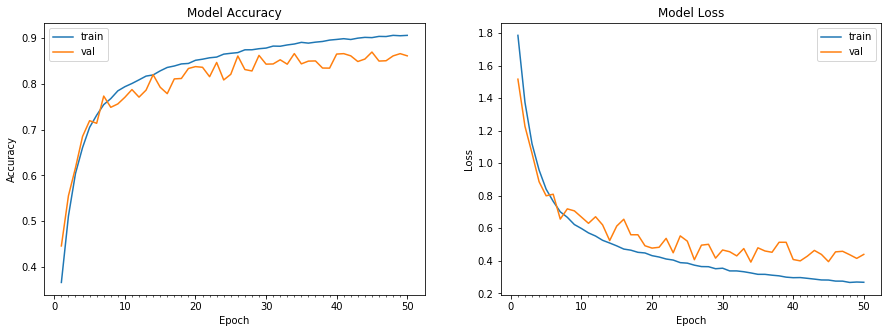

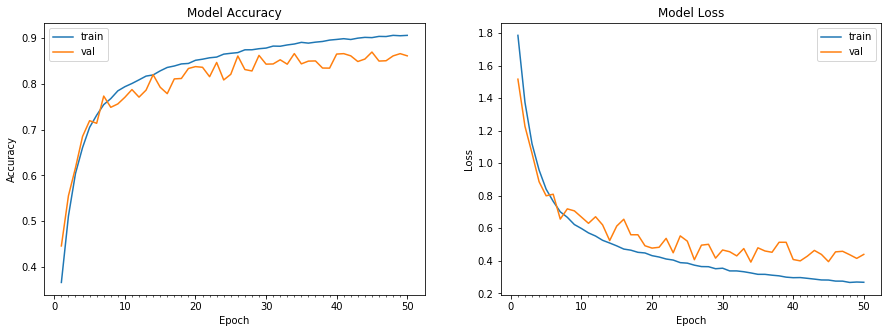

Accuracy on test data is: 86.09
Accuracy on test data is: 86.09


In [25]:
from keras.preprocessing.image import ImageDataGenerator
from keras.callbacks import ModelCheckpoint

datagen = ImageDataGenerator(
    featurewise_center=True,
    featurewise_std_normalization=True,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True)

checkpoint = ModelCheckpoint("best_weights.hdf5", monitor='val_acc', verbose=1, save_best_only=True, mode='max')

# train the model
start = time.time()
# Train the model
model_info = model.fit_generator(datagen.flow(train_features, train_labels, batch_size = 128),
                                 samples_per_epoch = train_features.shape[0], nb_epoch = 50, 
                                 validation_data = (test_features, test_labels), verbose=1,
                                 callbacks=[checkpoint])
end = time.time()
print ("Model took %0.2f seconds to train"%(end - start))
# plot model history
plot_model_history(model_info)
# compute test accuracy
print ("Accuracy on test data is: %0.2f"%accuracy(test_features, test_labels, model))